In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
%matplotlib inline

"""
El objetivo es calcular AUC:
La curva ROC grafica: Tasa de verdaderos positivos (sensibilidad) vs. Tasa de falsos positivos.
AUC: área bajo la curva ROC. Mide qué tan bien el modelo separa la clase positiva de la negativa.
Cuanto más cerca de 1.0, mejor. Un modelo aleatorio tiene AUC ≈ 0.5

Luego, se buscará el valor de n_estimators para el cual el OOB error es menor en un RandomForest.

Por último, se verá la condición del mínimo de muestras que debe haber en una hoja del arbol:
min_samples_leaf
"""

'\nEl objetivo es calcular AUC:\nLa curva ROC grafica: Tasa de verdaderos positivos (sensibilidad) vs. Tasa de falsos positivos.\nAUC: área bajo la curva ROC. Mide qué tan bien el modelo separa la clase positiva de la negativa.\nCuanto más cerca de 1.0, mejor. Un modelo aleatorio tiene AUC ≈ 0.5\n\nLuego, se buscará el valor de n_estimators para el cual el OOB error es menor en un RandomForest.\n\nPor último, se verá la condición del mínimo de muestras que debe haber en una hoja del arbol:\nmin_samples_leaf\n'

In [2]:
# Read the dataset and take a quick look
df = pd.read_csv("diabetes.csv")
df.head()


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [3]:
# Assign the predictor and response variables.
# Outcome is the response and all the other columns are the predictors
X = df.drop("Outcome", axis=1)
y = df['Outcome']


In [4]:
# Set the seed for reproducibility of results
seed = 0

# Split the data into train and test sets with the mentioned seed
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.33, 
                                                    random_state=seed)


### Vanila random forest

Start by training a Random Forest Classifier using the default parameters and calculate the Receiver Operating Characteristic Area Under the Curve (ROC AUC). As we know, this metric is better than accuracy for a classification problem, since it covers the case of an imbalanced dataset. 

In [5]:
### edTest(test_vanilla) ### 

"""
predict devuelve probabilidad 0 o 1

predict_proba: 
devuelve la probabilidad continua de un valor de pertenecer a cada clase en una matriz de probabilidades con dos columnas:
Columna 0 → probabilidad de clase 0 (no diabetes)
Columna 1 → probabilidad de clase 1 (diabetes) --> se usa este.
[:, 1] selecciona la segunda columna → probabilidad de clase 1 (caso positivo).

Explicación: le hago fit a un modelo RandomForest y calculo la probabilidad de cada X_train de tener diabetes.
"""

# Define a Random Forest classifier with randon_state = seed
vanilla_rf = RandomForestClassifier(random_state=seed) 

# Fit the model on the train data
vanilla_rf.fit(X_train, y_train)

# Calculate AUC/ROC on the test set
y_proba = vanilla_rf.predict_proba(X_test)[:, 1] 
auc = np.round(roc_auc_score(y_test, y_proba),2)
print(f'Plain RF AUC on test set:{auc}')


Plain RF AUC on test set:0.83


In [6]:
# Number of samples and features
num_features = X_train.shape[1]
num_samples = X_train.shape[0]
num_samples, num_features


(514, 8)

### 1. Number of trees, `num_iterators`, default = 100

The number of trees needs to be large enough for the $oob$ error to stabilize in its lowest possible value. Plot the $oob$ error of a random forest as a function of the number of trees. Trees in a RF are called `estimators`. A good start is 10 times the number of features, however, adjusting other hyperparameters will influence the optimum number of trees. 

In [7]:
"""
Queremos encontrar cuántos árboles (n_estimators) necesita el modelo para que el error OOB
se estabilice en su valor más bajo. 

Esto nos ayuda a evitar usar más árboles de los necesarios, ahorrando tiempo y recursos.

oob_error devuelve un número entre 0 y 1 que representa la exactitud del modelo sobre esas muestras OOB.
error_rate = 1 - exactitud
"""

#%%time
from collections import OrderedDict
clf = RandomForestClassifier(warm_start=True,       # Agrega árboles progresivamente sin reiniciar el modelo.
                               oob_score=True,      # Activa el cálculo oob para estimar el error.
                               min_samples_leaf=40, # Cada hoja debe tener al menos 40 muestras.
                               max_depth = 10,      # Los árboles no pueden crecer más de 10 niveles.
                               random_state=seed)

error_rate = {}

# Range of `n_estimators` values to explore.
min_estimators = 150
max_estimators = 500

for i in range(min_estimators, max_estimators + 1):
    clf.set_params(n_estimators=i)                  # Modifica hiperparámetros de clf (en este caso, n_estimators).
    clf.fit(X_train.values, y_train.values)         # Values pasa a array de numpy (no es necesario).

    # Record the OOB error for each `n_estimators=i` setting.
    oob_error = 1 - clf.oob_score_
    error_rate[i] = oob_error                       # Key: nro. iteración; Value: oob_error
    

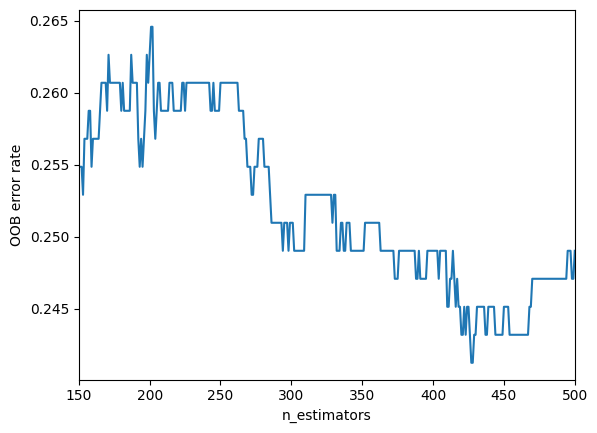

CPU times: total: 188 ms
Wall time: 227 ms


In [8]:
%%time
# Generate the "OOB error rate" vs. "n_estimators" plot.
# OOB error rate = num_missclassified/total observations (%)\
xs = []
ys = []
for label, clf_err in error_rate.items():
    xs.append(label)                            # label: clave de error_rate
    ys.append(clf_err)                          # clf_err: valor de error_rate
plt.plot(xs, ys)
plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.show();


### 2. `min_samples_leaf`, default = 1

The minimum number of samples required to be at a leaf node. A split point at any depth will only be considered if it leaves at least min_samples_leaf training samples in each of the left and right branches. This may have the effect of smoothing the model, especially in regression. We will plot various values of the `min_samples_leaf` with `num_iterators`. 

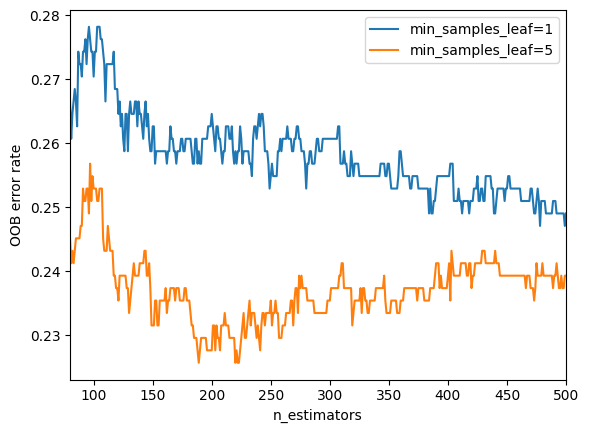

CPU times: total: 1min 29s
Wall time: 1min 29s


In [9]:
%%time

"""
Hago lo mismo pero para un arreglo de dos árboles con distinto min_samples_leaf.
"""

from collections import OrderedDict
ensemble_clfs = [
    (1,
        RandomForestClassifier(warm_start=True, 
                               min_samples_leaf=1,
                               oob_score=True,
                               max_depth = 10,
                               random_state=seed)),
    (5,
        RandomForestClassifier(warm_start=True, 
                               min_samples_leaf=5,
                               oob_score=True,
                               max_depth = 10,
                               random_state=seed))
]

# Map a label (the value of `min_samples_leaf`) to a list of (model, oob error) tuples.
error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

min_estimators = 80
max_estimators = 500

for label, clf in ensemble_clfs:
    for i in range(min_estimators, max_estimators + 1):
        clf.set_params(n_estimators=i) 
        clf.fit(X_train.values, y_train.values)

        # Record the OOB error for each model. Error is 1 - oob_score
        # oob_score: score of the training dataset obtained using an 
        # out-of-bag estimate.
        # OOB error rate is % of num_missclassified/total observations
        oob_error = 1 - clf.oob_score_
        error_rate[label].append((i, oob_error))

"""
label es la clave del diccionario (1 o 5, según min_samples_leaf)
clf_err es el valor asociado, que es una lista de tuplas con (n_estimators, oob_error)
Ej: clf_err = [(80, 0.22), (81, 0.218), (82, 0.215)]
"""

for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)                                  # Desempaqueta los valores.
    plt.plot(xs, ys, label=f'min_samples_leaf={label}')

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.legend(loc="upper right")
plt.show();


In [10]:
"""
Este bloque busca encontrar la mejor combinación de hiperparámetros 
(n_estimators y min_samples_leaf) que minimiza el error OOB.

n[0] → número de árboles (n_estimators)
n[1] → error OOB
La función lambda n: (n[1], -n[0]) transforma cada tupla en un par de comparación.
Da vuelta los índices de cada tupla para luego poder ordenar OOB con min().

Si dos OOB son iguales, se utiliza el que más árboles tenga.
Porque si tengo el mismo error usando más árboles, esa situación va a ser peor.

Se utiliza -n para cambiar de signo cada valor y comparar por cantidad de árboles.
Entonces, el mínimo va a ser el que más negativo (es decir el que tenga más árboles en valor absoluto).
"""

err = 100
best_num_estimators = 0
for label, clf_err in error_rate.items():
    num_estimators, error = min(clf_err, key=lambda n: (n[1], -n[0]))
    if error<err: err=error; best_num_estimators = num_estimators; best_leaf = label

print(f'Optimum num of estimators: {best_num_estimators} \nmin_samples_leaf: {best_leaf}')

"""
Para cada árbol (label) dentro de la lista: 
    Asigno a err el error correspondiente hallado y su n_estimators. 
    A ese árbol lo guardo en best_leaf. 
Entonces, de la lista de árboles con diferentes min_samples_leaf, encontré el que tiene menos error.
"""


Optimum num of estimators: 223 
min_samples_leaf: 5


'\nPara cada árbol (label) dentro de la lista: \n    Asigno a err el error correspondiente hallado y su n_estimators. \n    A ese árbol lo guardo en best_leaf. \nEntonces, de la lista de árboles con diferentes min_samples_leaf, encontré el que tiene menos error.\n'

Re-train the Random Forest Classifier using the new values for the parameters and calculate the AUC/ROC. Include another parameter, the `max_features`, the number of features to consider when looking for the best split. 

In [11]:
### edTest(test_estimators) ### 

"""
Se usan los hiperparámetros óptimos encontrados (best_num_estimators, best_leaf) 
y se agrega max_features='sqrt' para controlar cuántas variables se consideran en cada split.
"""

estimators_rf = RandomForestClassifier(n_estimators= best_num_estimators,
                                    random_state=seed,
                                    oob_score=True,
                                    min_samples_leaf=best_leaf,
                                    max_features='sqrt') 

# Fit the model on the train data
estimators_rf.fit(X_train, y_train);

# Calculate AUC/ROC on the test set
y_proba = estimators_rf.predict_proba(X_test)[:, 1]

estimators_auc = np.round(roc_auc_score(y_test, y_proba),2)
print(f'Educated RF AUC on test set:{estimators_auc}')


Educated RF AUC on test set:0.84


Look at the model's parameters

In [12]:
estimators_rf.get_params()


{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 5,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 223,
 'n_jobs': None,
 'oob_score': True,
 'random_state': 0,
 'verbose': 0,
 'warm_start': False}

### 3. Performing a cross-validation search

After we have some idea of the range of optimum values for the number of trees and maybe a couple of other parameters, and have enough computing power, you may perform an exhaustive search over other parameter values.

In [13]:
%%time
from sklearn.model_selection import GridSearchCV

do_grid_search = True

if do_grid_search:
    rf = RandomForestClassifier(n_jobs=-1,
                               n_estimators= best_num_estimators,
                               oob_score=True,
                               max_features = 'sqrt',
                               min_samples_leaf=best_leaf,
                               random_state=seed)

    param_grid = {
        'min_samples_split': [2,5]}
    
    scoring = {'AUC': 'roc_auc'}
    
    grid_search = GridSearchCV(rf, 
                               param_grid, 
                               scoring=scoring, 
                               refit='AUC', 
                               return_train_score=True, 
                               n_jobs=-1)
    
    results = grid_search.fit(X_train, y_train)
    print(results.best_estimator_.get_params())
    best_rf = results.best_estimator_
    # Calculate AUC/ROC
    y_proba = best_rf.predict_proba(X_test)[:, 1]
    auc = np.round(roc_auc_score(y_test, y_proba),2)
    print(f'GridSearchCV RF AUC on test set:{auc}')
    

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 5, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 223, 'n_jobs': -1, 'oob_score': True, 'random_state': 0, 'verbose': 0, 'warm_start': False}
GridSearchCV RF AUC on test set:0.84
CPU times: total: 719 ms
Wall time: 6.16 s
